# Sample Clarius Analysis

In [1]:
import os
from pathlib import Path

Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS/CLI-Demos')

In [2]:
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS')

# Select Image & Phantom and Parse

In [3]:
from src.Parsers.clariusRfParser import getClariusData

rf_path = '/media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.raw'
rf_tgc_path = '/media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml'
info_path = '/media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_rf.yml'

imgData, imgInfo, refData, refInfo = getClariusData(rf_path, rf_tgc_path, info_path,
                                                    rf_path, rf_tgc_path, info_path)

The number of missing timestamps for /media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.
The number of missing timestamps for /media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/2024-11-01T11-36-16+0000_env.tgc.yml is: 30. Skipping this scan with current criteria.
A default TGC matrix of size (192, 2928, 30) is generated.
A default TGC matrix of size (192, 2928, 30) is generated.


# ROI Selection (from GUI)

In [4]:
import pickle

pkl_name = Path("/media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/roi.pkl")

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

In [5]:
assert roi_info['Image Name'] == Path(rf_path).name
assert roi_info['Phantom Name'] == Path(rf_path).name

In [14]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [7]:
from pyQus.analysisObjects import Config

pkl_name = Path("/media/das/CREST Data/David_S_Data/Clarius_RF_Data/f2540449-af21-4e92-aef6-45ecfd28dd6f/analysis-config.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [8]:
assert config_info["Image Name"] == Path(rf_path).name
assert config_info["Phantom Name"] == Path(rf_path).name

In [9]:
config = config_info["Config"]

# Spectral Analysis

In [29]:
from pyQus.analysisObjects import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.scBmode = imgData.scBmode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]
ultrasoundImage.xmap = imgData.scBmodeStruct.xmap
ultrasoundImage.ymap = imgData.scBmodeStruct.ymap

In [30]:
from pyQus.spectral import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [31]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/home/das/QuantUS_Projs/QuantUS/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/das/QuantUS_Projs/QuantUS/pyQus/spectral.py:193: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)


# Visualizations

In [32]:
from src.DataLayer.spectral import SpectralData
from src.DataLayer.dataObjects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfo.width1
scConfig.tilt = imgInfo.tilt1
scConfig.startDepth = imgInfo.startDepth1
scConfig.endDepth = imgInfo.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [33]:
spectralData.convertImagesToRGB()

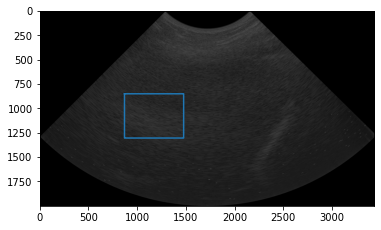

In [35]:
import matplotlib.pyplot as plt

plt.imshow(spectralData.scBmode)
plt.plot(scSplineX, scSplineY)

In [36]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

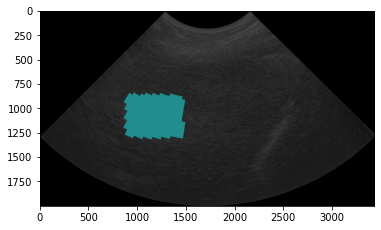

In [38]:
# Note cmap is solid as image = phantom in this case
plt.imshow(spectralData.scMbfIm) 